# Cell Cycles Trajectory Inference

This notebook provides tutorial in trajectory inference in cell cycles using Curly Flow Matching on the human fibroblast data. For inference and higher dimensions please refer to $\texttt{src/models/deepcycle.py}$

For pre-processing data and dataset visualizations, please see [pre-processing notebook](cells_data.ipynb)

In [ ]:
# load in necessary packages
import math
import sys, os
import time

sys.path.append(os.path.abspath("..")) 

import scanpy as sc
import scvelo as scv

import torch

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons
import torchcfm
from torchcfm.utils import *
from sklearn.datasets import make_circles
from torchcfm.optimal_transport import OTPlanSampler
from src.models.components.single_marginal_utils import *
from src.models.components.mlp import * 


2025-11-28 03:27:00.752505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 03:27:00.771222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764300420.790359  569679 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764300420.795930  569679 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764300420.812249  569679 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Curly Flow Matching 

In [3]:
# set seed
torch.manual_seed(0)
np.random.seed(0)

## Load Data

In [ ]:
# Load data
import scanpy as sc
adata_path = "../data/DeepCycle/fibroblast_velocity.h5ad"
adata = sc.read_h5ad(adata_path)
X = torch.from_numpy(adata.obsm["X_umap"])
v_x, v_y = get_cell_velocities(adata)
V = torch.stack([v_x, v_y], dim=1)


In [5]:
# Hyperparameters and models
w2s = []
time_list = []

# Model Training 

1000: loss 0.560 time 8.66
2000: loss 0.411 time 15.29
3000: loss 0.360 time 21.92
4000: loss 0.257 time 28.56
5000: loss 0.332 time 35.32
6000: loss 0.298 time 42.08
7000: loss 0.269 time 48.74
8000: loss 0.377 time 55.47
9000: loss 0.364 time 62.27
10000: loss 0.254 time 69.01


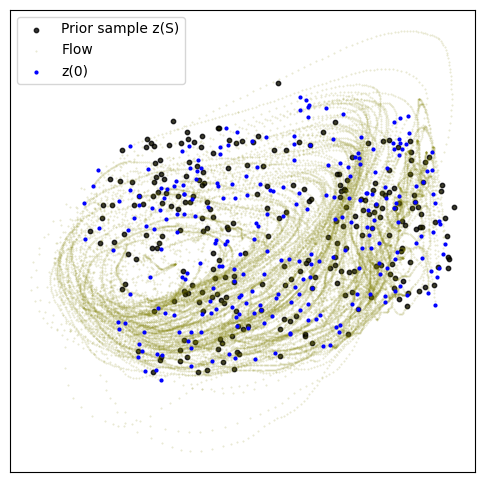

In [6]:
# Algorithm 1
sigma = 0.01
dim = 2
batch_size = 256
alpha = 0.01
interpolant_net = MLP(dim=2*dim, out_dim=dim, time_varying=True)
optimizer_int = torch.optim.Adam(list(interpolant_net.parameters()))
start = time.time()

# Training loop for psi_t and xt_dot
for k in range(10000):
    optimizer_int.zero_grad()
    x0 = X[torch.randperm(X.shape[0], device=X.device)[:batch_size]]
    x1 = X[torch.randperm(X.shape[0], device=X.device)[:batch_size]]
    t = torch.rand(x0.shape[0]).type_as(x0)
    xt, mu_t_dot, eps = get_xt_xt_dot(t, x0, x1, interpolant_net, sigma = sigma)
    ut = get_u_xt(xt, X, V)
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(ut, mu_t_dot).mean()
    l2_loss = torch.mean((ut - alpha*mu_t_dot) ** 2)
    loss = cosine_loss + l2_loss
    loss.backward()
    optimizer_int.step()
    traj = []
    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

with torch.no_grad():
    for t in torch.linspace(0, 1, 100): 
        t = t.type_as(x0).repeat(x0.shape[0])
        t = t[:,None]
        xt_traj = get_xt(t, x0, x1, interpolant_net)[1]
        traj.append(xt_traj)

traj = torch.stack(traj)
plot_trajectories(traj.cpu().numpy())

1000: loss 85.917 time 342.26
2000: loss 89.164 time 274.70


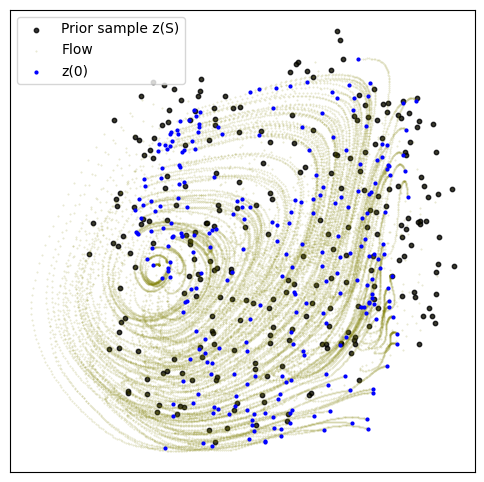

2000: loss 89.164 time 0.00 w2 1.263


In [7]:
# Algorithm 2
model = MLP(dim=dim, out_dim=dim, time_varying=True)
optimizer_velocity = torch.optim.Adam(list(model.parameters()))
for k in range(2000):
    optimizer_velocity.zero_grad()
    x0 = X[torch.randperm(X.shape[0], device=X.device)[:batch_size]]
    x1 = X[torch.randperm(X.shape[0], device=X.device)[:batch_size]]
    x0, x1 = coupling(x0, x1, x0.shape[0], X, V, interpolant_net, sigma=sigma)
    t = torch.rand(x0.shape[0]).type_as(x0)
    xt, mu_t_dot, eps = get_xt_xt_dot(t, x0, x1, interpolant_net, sigma=sigma)
    vt = model(torch.cat([xt.detach(), t[:, None]], dim=-1))
    loss = torch.mean((vt - mu_t_dot.detach()) ** 2)
    loss.backward()
    optimizer_velocity.step()
    time_list.append(k)
    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
    
node = NeuralODE(
    torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100),
    )
    if (k + 1) % 10000 == 0:
        torch.save(traj, f"traj_{k}.pt")
    plot_trajectories(traj.cpu().numpy())

w2 = torchcfm.optimal_transport.wasserstein(traj[-1], x1)
w2s.append(w2)
print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f} w2 {w2:0.3f}")
start = end